<a href="https://colab.research.google.com/github/acmenoita/Pratical-Machine-Learning/blob/Assignment-%232/Aquifer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
from google.colab import files
uploaded = files.upload()

Saving aquifer_time_series.csv to aquifer_time_series.csv


In [14]:
df = pd.read_csv("aquifer_time_series.csv")
df["date"] = pd.to_datetime(df["date"], dayfirst=True)

df_monthly = df.groupby(df["date"].dt.to_period("M")).median(numeric_only=True)
df_monthly["date"] = df_monthly.index.to_timestamp()
df_monthly.reset_index(drop=True, inplace=True)

In [15]:
def create_lagged_features(df, target_col, lags=12):
    df_lagged = df.copy()
    for col in df.columns:
        if col == "date" or col == target_col:
            continue
        for lag in range(lags + 1):
            df_lagged[f"{col}(t-{lag})"] = df[col].shift(lag)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged

target = "depth_to_groundwater_m"
df_lagged = create_lagged_features(df_monthly, target_col=target, lags=12)

feature_cols = [col for col in df_lagged.columns if "(t-" in col]
X = df_lagged[feature_cols].select_dtypes(include=[np.number])
y = df_lagged[target]
groups = df_lagged["date"].dt.to_period("Q")


In [17]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(random_state=42))
])

In [19]:
cv = GroupKFold(n_splits=5)
scores = cross_val_score(pipeline, X, y, cv=cv, groups=groups, scoring="r2")
print(f"Cross-validated R^2: {scores.mean():.2f} ± {scores.std():.2f}")

pipeline.fit(X, y)
y_pred = pipeline.predict(X)

Cross-validated R^2: 0.39 ± 0.09


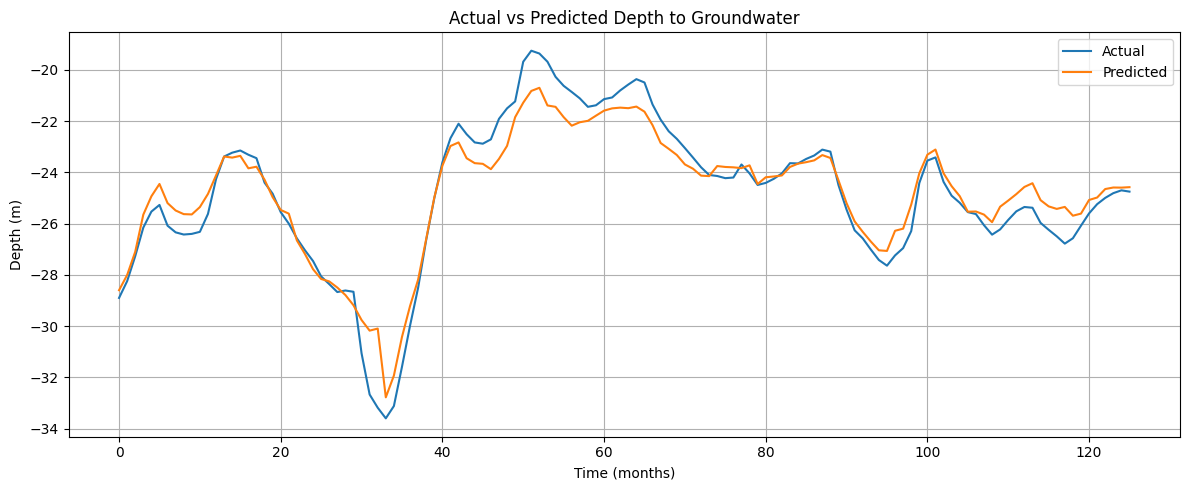

In [20]:
plt.figure(figsize=(12, 5))
plt.plot(y.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("Actual vs Predicted Depth to Groundwater")
plt.xlabel("Time (months)")
plt.ylabel("Depth (m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()